## Importação das bibliotecas

In [11]:
#importar bibliotecas básicas de EDA e Visualização
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
# classe de obtenção dos dados
from Acao import Acao
# bibliotecas de ML
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.core import StatsForecast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go
import os
import joblib
from sklearn.preprocessing import MinMaxScaler

In [12]:
# IMPORTAR PARA IGNORAR OS WARNINGS DO SISTEMA E NÃO POLUIR AS SAÍDAS
#-------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## CONFIGURAÇÕES

O parâmetro X é escolhido conforme o dicionário abaixo, escolha o número conforme o papel desejado para treinamento.



In [13]:
# TICKERS UTILIZADOS
#----------------------------------------
dict_acoes = {
    1: ['BANCO_DO_BRASIL', 'BBAS3.SA'],
    2: ['IBOVESPA', '^BVSP']
}

In [14]:
#------------------------------------
# CONFIGURAÇÕES
#-----------------------------------

X = 2
PAPEL = dict_acoes[X][0]
MODEL_NAME = "StatsForecast AutoARIMA"
MODEL_PATH = "app/models/"
METADATA_PATH = "app/metadata/"
DATA_FINAL = '2026-01-13'

#os.makedirs('../.venv/app/models')
#os.makedirs('../.venv/app/metadata')

In [15]:
# df É O DATAFRAME COM OS DADOS COLETADOS DO PAPEL
#----------------------------------------------------------
papel = dict_acoes[X][1]
acao = Acao(papel)
df = acao.retorna_df('10y', pd.to_datetime(DATA_FINAL))

[*********************100%***********************]  1 of 1 completed

Retornando os dados do papel ^BVSP, no período de 10y


## FUNÇÕES

###  DEFINIR A MÉTRICA DE VALIDAÇÃO DO MODELO

### $$WMAPE$$ sigla para Weighted Mean Absolute Percentage Error (Erro Percentual Absoluto Médio Ponderado), é um indicador que mede a acurácia de previsões (forecasts) de forma ponderada, dando mais importância a itens ou períodos de maior volume ou relevância, o que o torna mais estratégico que o MAPE puro, ajudando a identificar desvios significativos no planejamento de demanda e produção.

In [16]:
def wmape(y_true, y_pred):
  resultado = (np.abs(y_true - y_pred).sum() / np.abs(y_true).sum())
  return resultado

### FUNÇÃO QUE CRIA A TARGET NA TABELA DE PREVISÃO FINAL, PARA CÁLCULO DE ACURÁCIA

In [17]:
# VERIFICAÇÃO DA ACURÁCIA DOS MODELOS ATRAVÉS DA CRIAÇÃO DE UMA VARIÁVEL TARGET
def resultado_target(abertura, fechamento):
    val_ab = abertura.values
    val_fc = fechamento.values
    delta = val_ab - val_fc
    resultado = delta
    for i in range(len(delta)):
        resultado[i] = (2 if delta[i] < 0 else (1 if delta[i] == 0 else 0))
    return resultado

## AJUSTE DO DF DO YFINANCE PARA O STATSFORECAST

In [ ]:
# ADEQUAR O DATAFRAME DO YFINANCE PARA O PADRÃO DO STATSFORECAST
df_stats_2 = df[['fechamento']].copy()
df_stats_2 = df_stats_2.dropna()
df_stats_2 = df_stats_2.reset_index()
df_stats_2['unique_id'] = 1
df_stats_2 = df_stats_2.rename(columns={'fechamento':'y', 'Date': 'ds'})
df_stats_2.tail()

h=5 #horizonte de previsão
limite = df.index[-h] #data limite do treino
treino_stats_2 = df_stats_2.loc[df_stats_2['ds'] < limite] #DF de treino
#aplicar o min/max scaler
scaler = MinMaxScaler()
treino_stats_2['y'] = scaler.fit_transform(treino_stats_2['y'].values.reshape(-1,1)).flatten()
joblib.dump(scaler, f'{MODEL_PATH}scaler_{PAPEL}.pkl') # salva o scaler para realizar a conversão inversa no app
#-------------------------------------------------------------------
teste_stats_2 = df_stats_2.loc[df_stats_2['ds'] >= limite] #DF de teste

### PREVISÃO E CONVERSÃO INVERSA DA TARGET PELO SCALER

In [ ]:
model_ar = StatsForecast(models=[ARIMA(order=(8,2,21))], freq='B', n_jobs=-1) # order com melhores resultados

model_ar.fit(treino_stats_2)

df_pred_ar = model_ar.predict(h=h)

joblib.dump(model_ar, f'{MODEL_PATH}model_{PAPEL}.pkl') # salva o modelo principal onde PAPEL é a ação ou índice escolhido nas configurações acima

with open(f'{METADATA_PATH}meta_{PAPEL}.txt', 'w', encoding='utf-8') as f:
    f.write(f'model_name={MODEL_NAME}\n')
    f.write(f'data_treino={limite}\n')
    f.write(f'data_teste={DATA_FINAL}\n')
    f.write(f'papel={PAPEL}\n')

df_pred_ar['ARIMA'] = scaler.inverse_transform(df_pred_ar['ARIMA'].values.reshape(-1,1)).flatten()
df_pred_ar.tail()

,unique_id,ds,ARIMA
0,1,2026-01-06,161262.325762
1,1,2026-01-07,161717.049473
2,1,2026-01-08,162101.982059
3,1,2026-01-09,161994.099303
4,1,2026-01-12,162394.939733


### 

In [ ]:
# ADICIONAMOS AO DF DE PREVISÃO A ABERTURA E O FECHAMENTO ORIGINAIS PARA CÁLCULOS DE PERFORMANCE
abertura = df.loc[df.index >= limite]['abertura'].values
df_pred_ar = df_pred_ar.merge(df_stats_2[['ds','y']], on='ds', how='left')
df_pred_ar['abertura'] = abertura
df_pred_ar.head()

,unique_id,ds,ARIMA,y,abertura
0,1,2026-01-06,161262.325762,163664.0,161870.0
1,1,2026-01-07,161717.049473,161975.0,163661.0
2,1,2026-01-08,162101.982059,162937.0,161975.0
3,1,2026-01-09,161994.099303,163370.0,162938.0
4,1,2026-01-12,162394.939733,163150.0,163370.0


Precisao modelo: 60.00%
WMAPE modelo: 0.69%


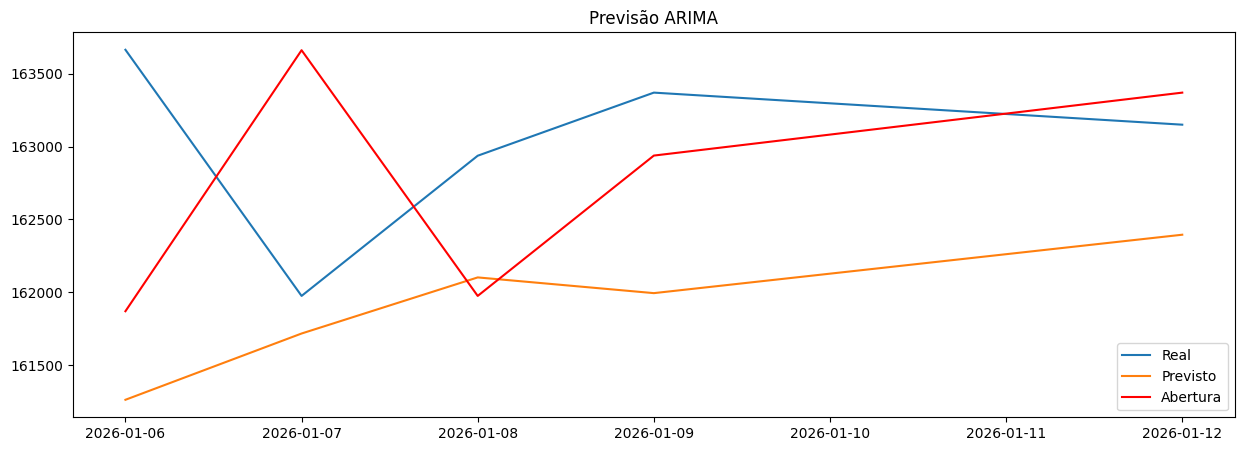

In [ ]:
# CRIAÇÃO DAS TARGETS (DIFERENÇA ENTRE ABERTURA E FECHAMENTO) QUE DETERMINAM SE AÇÃO SUBIU OU DESCEU
df_pred_ar['target'] = resultado_target(df_pred_ar['abertura'], df_pred_ar['y'])
df_pred_ar['target_arima'] = resultado_target(df_pred_ar['abertura'], df_pred_ar['ARIMA'])
a = wmape(df_pred_ar['y'].values, df_pred_ar['ARIMA'].values)
precisao = accuracy_score(df_pred_ar['target'], df_pred_ar['target_arima'])

print(f'Precisao modelo: {precisao:.2%}')
print(f'WMAPE modelo: {a:.2%}')

# PLOT DO GRÁFICO# Comparar com o real
#-----------------------------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(df_pred_ar['ds'], df_pred_ar['y'], label='Real')
plt.plot(df_pred_ar['ds'], df_pred_ar['ARIMA'], label='Previsto')
plt.plot(df_pred_ar['ds'], df_pred_ar['abertura'], label='Abertura', color='r')
plt.legend()
plt.title('Previsão ARIMA')
plt.show()